## Problem 6.6

In this method we will use the Lax-Friedrichs method for solving the velocity-stress formulation: 

$$
\begin{align*}
v_j^{n+1} &= \frac{1}{2} \left( v_{j+1}^n + v_{j-1}^n \right) + \frac{\Delta t}{\rho_j} \frac{\sigma_{j+1}^n - \sigma_{j-1}^n}{2\, \Delta x} \\ 
\sigma_j^{n+1} &= \frac{1}{2} \left( \sigma^n_{j+1} + \sigma^n_{j-1} \right) + \Delta t \, \mu_j \frac{v^n_{j+1} - v_{j-1}^n}{2\, \Delta x} \quad.
\end{align*}
$$

We will compare our solution against the method from Problem 6.4. To do this, we will simultaneously solve for each system at each time step. There are therefore a lot of arrays to track! Anything with ```LF_``` is related to the Lax-Freidrichs method.  

First let us define our domain: 

In [1]:
import numpy as np  
import matplotlib.pyplot as plt 
from copy import copy

# Domain parameters
L  = 100
dx = 0.1

# Switch for dirichlet bc
# set to false for Neumann
DBC = True 

# 1D Array holding grid points, x
x = np.arange(0, L+dx, dx)

# Number of grid points in x
N = len(x)

# CENTERED FD arrays 
v_old       = np.zeros(N)
s_old       = np.zeros(N)

v           = np.zeros(N)
sigma       = np.zeros(N)

v_new       = np.zeros(N)
s_new       = np.zeros(N)

# Lax Freidrichs arrays 
LF_v        = np.zeros(N)
LF_sigma    = np.zeros(N)

LF_v_new    = np.zeros(N)
LF_s_new    = np.zeros(N)


# Material properties - this is an array in so
# properties can be defined at each point in the grid
rho = np.zeros(N) + 1
mu  = np.zeros(N) + 1

### CFL condition 
Let us compute our timestep based on a Courant number of 0.5 

In [2]:
beta = np.sqrt(np.max(mu)/np.min(rho))
C    = 0.5
dt   = dx * C / beta

### Initial conditions
Next let us define a function that provides updates the velocity, $v$, with the initial condition

In [3]:
def apply_initial_condition(x, v, sigma):
    # Equation 6.50
    sigma[:] = 0
    v = -0.2 * (x-50) * np.exp(-0.1*(x-50)**2)
    return v, sigma

### Solver

We now define the solver that iterates in time. Unlike in Problem 6.4, this formalisation only relies on the current timestep. The function below iterates the system one timestep. For comparison, we also copy over the centered finite difference method function from Problem 6.4.

In [4]:
def Lex_step_in_time(s, s_new, v, v_new, dx, dt, mu, rho, use_Dirichlet_BC):
    # Notes on slicing:
    # [1:-1] includes all points except boundaries
    # [2:  ] is from 3rd to end
    # [:-2 ] is from start to 3rd-last (missing last two points)

    # [1:-1] represents lower index = j
    # [2:  ] represents lower index = j + 1
    # [:-2 ] represents lower index = j - 1

    # Variable names (s and v):
    # s for sigma, v for v (velocity)
    # ? below means s or v
    # ?_new  represents superscript = n + 1
    # ?      represents superscript = n

    # Compute new v and s
    v_new[1:-1] = 0.5*(v[2:]+v[:-2]) + (dt / (2* rho[1:-1] * dx)) * (s[2:] - s[:-2])
    
    s_new[1:-1] = 0.5*(s[2:]+s[:-2]) + (dt * mu[1:-1] / (2*dx))   * (v[2:] - v[:-2])

    # Apply boundary conditions:
    if use_Dirichlet_BC:
        # Dirichlet:
        v_new[0]  = 0
        v_new[-1] = 0

        # Use a 1-sided gradient approximation for the edges:
        s_new[0]  = s[0]  +  dt * mu[0]  *  v[1] / dx
        s_new[-1] = s[-1] -  dt * mu[-1] * v[-2] / dx
    else:
        s_new[0]  = 0
        s_new[-1] = 0

        v_new[0]  = v[0]  + dt *   s[1] / (dx * rho[0])
        v_new[-1] = v[-1] - dt *  s[-2] / (dx * rho[-1])

    return  v_new, s_new


# Centered finite difference from Problem 6.4
def step_in_time(s_old, s, s_new, v_old, v, v_new, dx, dt, mu, rho, use_Dirichlet_BC):
    v_new[1:-1] = v_old[1:-1] + (dt / (rho[1:-1] * dx)) * (s[2:] - s[:-2])
    s_new[1:-1] = s_old[1:-1] + (dt * mu[1:-1] / dx) * (v[2:] - v[:-2])

    # Apply boundary conditions:
    if use_Dirichlet_BC:
        # Dirichlet:
        v_new[0] = 0
        v_new[-1] = 0

        s_new[0]  = s_old[0]  + 2 * dt * mu[0]  * v[1] / dx
        s_new[-1] = s_old[-1] + 2 * dt * mu[-1] * -v[-2] / dx
    else:
        s_new[0] = 0
        s_new[-1] = 0

        v_new[0] = v_old[0] + 2 * dt * s[1] / (dx * rho[0])
        v_new[-1] = v_old[-1] - 2 * dt * s[-2] / (dx * rho[-1])

    return v, v_new, s, s_new


#### Running the solver

Finally, let us run the solver in time and plot the timesteps

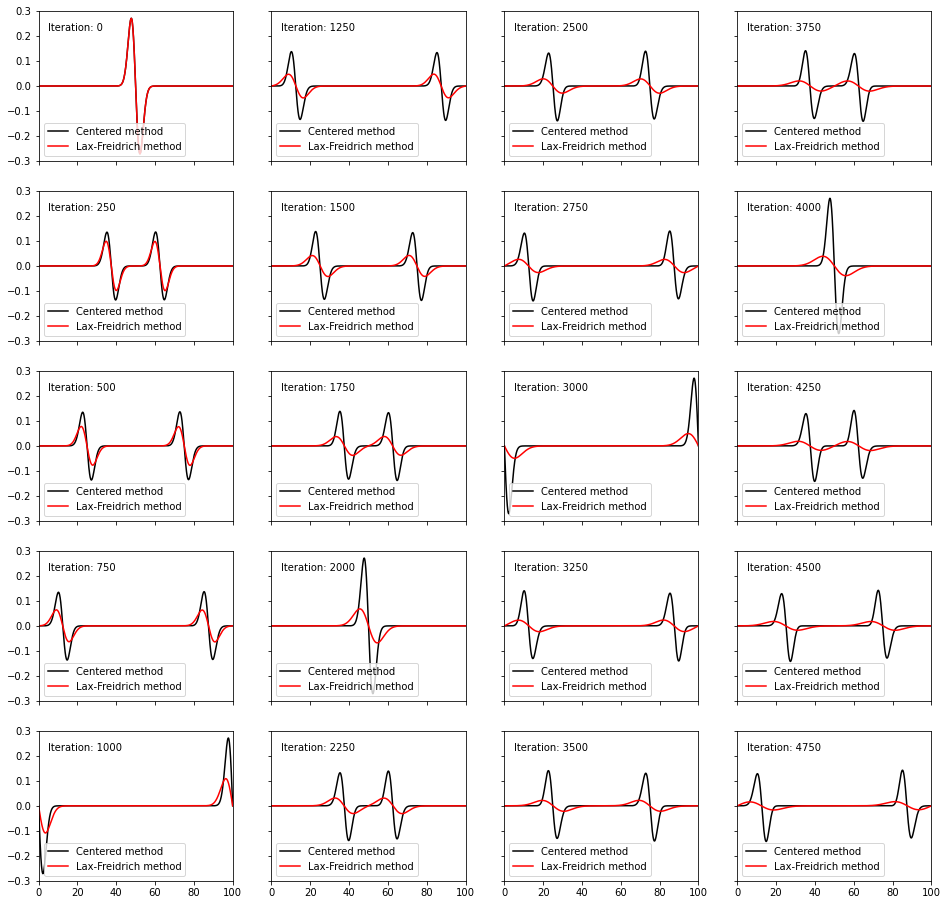

In [5]:
# Number of timesteps and steps to plot
nsteps        = 5000
plot_every    = 250
nplotcols     = 4
DBC           = True
plots_percol  = (nsteps//plot_every)//nplotcols

# Create Figure
fig, ax = plt.subplots(plots_percol, nplotcols, 
                       figsize=(16, 16), 
                       sharex=True, 
                       sharey=True)

# Apply initial conditions for FD method
v, sigma     = apply_initial_condition(x, v, sigma)
v_old, s_old = apply_initial_condition(x, v_old, s_old)


# Apply initial conditions for LF method 
LF_v, LF_sigma = apply_initial_condition(x, LF_v, LF_sigma)


# Iterate through timesteps 
iax  = 0 
icol = 0 
for i in range(nsteps):
    
    # CENTERED SCHEME FROM PROBLEM 6.4:
    v, v_new, sigma, s_new = step_in_time(s_old=s_old, 
                                          s=sigma, 
                                          s_new=s_new,
                                          v_old=v_old, 
                                          v=v, 
                                          v_new=v_new,
                                          dx=dx, dt=dt, 
                                          mu=mu, rho=rho,
                                          use_Dirichlet_BC=DBC)
    # Update timestep for FD method
    v_old[:] = v[:]
    s_old[:] = sigma[:]
    v[:]     = v_new[:]
    sigma[:] = s_new[:]
    
    
    # ----------- LEX-FRIEDRICH SCHEME --------------------
    LF_v_new, LF_s_new = Lex_step_in_time(s=LF_sigma, 
                                          s_new=LF_s_new,
                                          v=LF_v, 
                                          v_new=LF_v_new,
                                          dx=dx, 
                                          dt=dt, 
                                          mu=mu, 
                                          rho=rho,
                                          use_Dirichlet_BC=DBC)
    # Update timestep for LF method
    LF_sigma[:] = LF_s_new[:]
    LF_v[:]     = LF_v_new[:]


    # Plot 
    if i%plot_every==0:
        ax[iax, icol].plot(x, v, 'k')
        ax[iax, icol].plot(x, LF_v, 'r')
        ax[iax,icol].text(x=5, y = 0.22, s=f"Iteration: {i}")
        ax[iax,icol].set_xlim([0,100])
        ax[iax, icol].set_ylim([-0.3,0.3])
        ax[iax, icol].legend(['Centered method', 'Lax-Freidrich method'],
                             loc='lower left')
        iax += 1
        if iax == plots_percol: 
            iax = 0
            icol += 1

We observe the Lax-Freidrich method is doing a very poor job at reproducing the results of wave propagation. Why is this? This method is only 1st order accurate, but the main difference is due to the averaging that is employed. At each timestep the velocity and stress are being represented as 
\begin{align*}
v_j^n &\rightarrow \frac{1}{2} \left( v_{j+1}^n + v_{j-1}^n \right) \\ 
\sigma_j^n &\rightarrow \frac{1}{2} \left( \sigma_{j+1}^n + \sigma_{j-1}^n \right) \\ 
\end{align*}
as in Eqn 6.45. This means that we are averaging the values of these scalar fields spatially at each timestep, essentially smoothing the system and reducing high-frequency components. See, for example, iteration 1750 in which the true velocity field is being smoothed. This also results in disspiation of the amplitude through time. 

In the cell below, we re-run the entire system described above but using a smaller grid discretisation (5x smaller), to improve the accuracy. Note this also affects the timestep. 

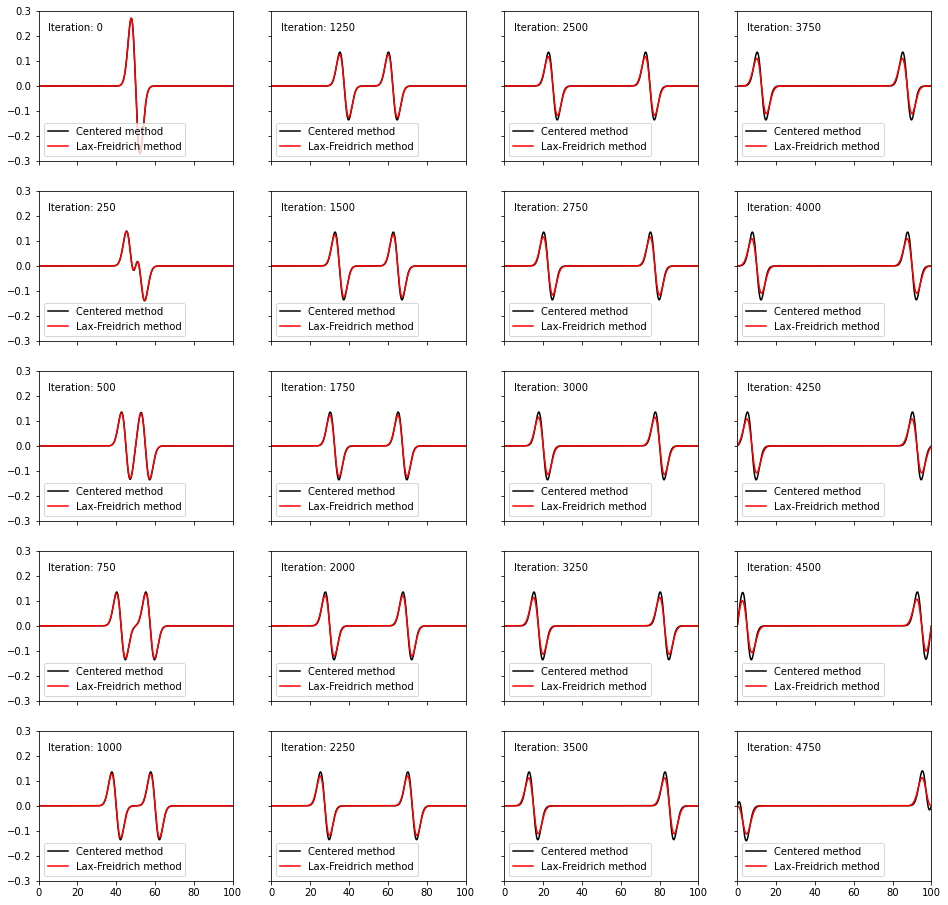

In [6]:
# Number of timesteps and steps to plot
nplotcols     = 4
plots_percol  = (nsteps//plot_every)//nplotcols

# Create Figure
fig, ax = plt.subplots(plots_percol, nplotcols, 
                       figsize=(16, 16), 
                       sharex=True, 
                       sharey=True)

dx   = 0.02
C    = 0.5
dt   = dx * C / beta

# 1D Array holding grid points, x
x = np.arange(0, L+dx, dx)

# Number of grid points in x
N = len(x)

# CENTERED FD arrays 
v_old       = np.zeros(N)
s_old       = np.zeros(N)

v           = np.zeros(N)
sigma       = np.zeros(N)

v_new       = np.zeros(N)
s_new       = np.zeros(N)

# Lax Freidrichs arrays 
LF_v        = np.zeros(N)
LF_sigma    = np.zeros(N)

LF_v_new    = np.zeros(N)
LF_s_new    = np.zeros(N)


# Material properties - this is an array in so
# properties can be defined at each point in the grid
rho = np.zeros(N) + 1
mu  = np.zeros(N) + 1


# Apply initial conditions for FD method
v, sigma     = apply_initial_condition(x, v, sigma)
v_old, s_old = apply_initial_condition(x, v_old, s_old)


# Apply initial conditions for LF method 
LF_v, LF_sigma = apply_initial_condition(x, LF_v, LF_sigma)


# Iterate through timesteps 
iax  = 0 
icol = 0 
for i in range(nsteps):
    
    # CENTERED SCHEME FROM PROBLEM 6.4:
    v, v_new, sigma, s_new = step_in_time(s_old=s_old, 
                                          s=sigma, 
                                          s_new=s_new,
                                          v_old=v_old, 
                                          v=v, 
                                          v_new=v_new,
                                          dx=dx, dt=dt, 
                                          mu=mu, rho=rho,
                                          use_Dirichlet_BC=DBC)
    # Update timestep for FD method
    v_old[:] = v[:]
    s_old[:] = sigma[:]
    v[:]     = v_new[:]
    sigma[:] = s_new[:]
    
    
    # ----------- LEX-FRIEDRICH SCHEME --------------------
    LF_v_new, LF_s_new = Lex_step_in_time(s=LF_sigma, 
                                          s_new=LF_s_new,
                                          v=LF_v, 
                                          v_new=LF_v_new,
                                          dx=dx, 
                                          dt=dt, 
                                          mu=mu, 
                                          rho=rho,
                                          use_Dirichlet_BC=DBC)
    # Update timestep for LF method
    LF_sigma[:] = LF_s_new[:]
    LF_v[:]     = LF_v_new[:]


    # Plot 
    if i%plot_every==0:
        ax[iax, icol].plot(x, v, 'k')
        ax[iax, icol].plot(x, LF_v, 'r')
        ax[iax,icol].text(x=5, y = 0.22, s=f"Iteration: {i}")
        ax[iax,icol].set_xlim([0,100])
        ax[iax, icol].set_ylim([-0.3,0.3])
        ax[iax, icol].legend(['Centered method', 'Lax-Freidrich method'],
                             loc='lower left')
        iax += 1
        if iax == plots_percol: 
            iax = 0
            icol += 1

In this case, we observe far better agreement between the two numerical methods, since the grid spacing is sufficiently small to prevent averaging-out of high-frequency wavefield components. However, we still observe dissipation in the amplitude due to this averaging. 

### Inhomogeneous Domain

Let us now consider the case of an inhomogeneous domain in which the shear modulus changes from $\mu = 1$ for $x \in [0,\,65]$ to $\mu = 4$ for $x \in [65,\,100]$. Once again, we will compare with the method used in Problem 6.4. 

In [7]:
# Material properties - this is an array in so
# properties can be defined at each point in the grid
rho = np.zeros(N) + 1
mu  = np.zeros(N) + 1

# For the region where x is greater than 65 we will now edit the shear values: 
mu[x > 65] = 4

Since we have changed our domain, we need to update timestep based on the CFL condition. Note here we are still using the finer grid spacing of dx = 0.02. 

In [8]:
# We also need to update our CFL condition: 
beta = np.sqrt(np.max(mu)/np.min(rho))
C = 0.5
dt = dx * C / beta

Once again, we run the solver. This time, we observe the expected reflection at the boundary in shear modulus properties ($x = 65$). Boundaries can also be a position of discrepency when using the Lax-Freidrich method since wavefield properties are being averaged across the boundary. Consider, for example, the case in which the shear modulus was equal to 0 in one section, i.e. it is a fluid. No wave should propagate within the fluid, so the velocity is 0. However the averaging scheme 
\begin{align*}
v_j^n &\rightarrow \frac{1}{2} \left( v_{j+1}^n + v_{j-1}^n \right) \\ 
\sigma_j^n &\rightarrow \frac{1}{2} \left( \sigma_{j+1}^n + \sigma_{j-1}^n \right) \\ 
\end{align*}
may allow for non-zero velocity values if, for example, one of  $v_{j+1}^n$, or $v_{j-1}^n$ lay within the solid region.

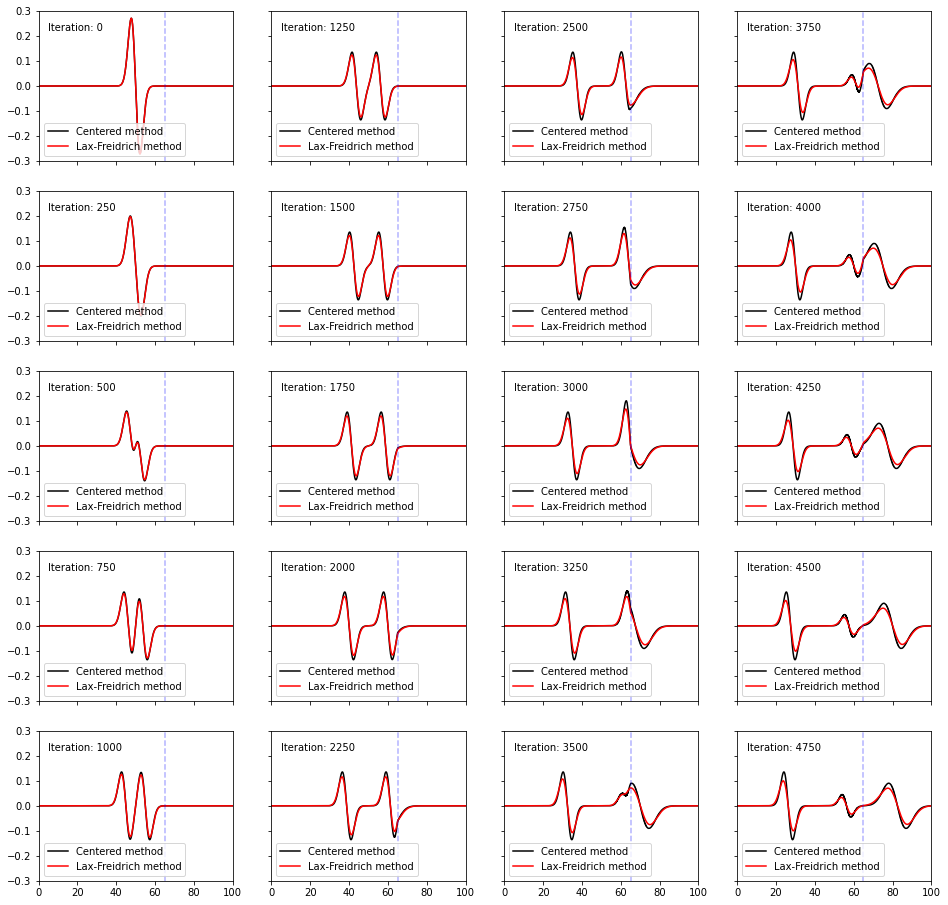

In [9]:
# Apply initial conditions for Centered method
v, sigma     = apply_initial_condition(x, v, sigma)
v_old, s_old = apply_initial_condition(x, v_old, s_old)


# Apply initial conditions for LF method 
LF_v, LF_sigma = apply_initial_condition(x, LF_v, LF_sigma)


# Create Figure
fig, ax = plt.subplots(plots_percol, nplotcols, 
                       figsize=(16, 16), 
                       sharex=True, 
                       sharey=True)

# Iterate through timesteps 
iax  = 0 
icol = 0 
for i in range(nsteps):
  
    # CENTERED SCHEME FROM PROBLEM 6.4:
    v, v_new, sigma, s_new = step_in_time(s_old=s_old, 
                                          s=sigma, 
                                          s_new=s_new,
                                          v_old=v_old, 
                                          v=v, 
                                          v_new=v_new,
                                          dx=dx, dt=dt, 
                                          mu=mu, rho=rho,
                                          use_Dirichlet_BC=DBC)
    # Update timestep for FD method
    v_old[:] = v[:]
    s_old[:] = sigma[:]
    v[:]     = v_new[:]
    sigma[:] = s_new[:]
    
    
    # ----------- LEX-FRIEDRICH SCHEME --------------------
    LF_v_new, LF_s_new = Lex_step_in_time(s=LF_sigma, 
                                          s_new=LF_s_new,
                                          v=LF_v, 
                                          v_new=LF_v_new,
                                          dx=dx, 
                                          dt=dt, 
                                          mu=mu, 
                                          rho=rho,
                                          use_Dirichlet_BC=DBC)
    # Update timestep for LF method
    LF_sigma[:] = LF_s_new[:]
    LF_v[:]     = LF_v_new[:]


    # Plot 
    if i%plot_every==0:
        ax[iax, icol].plot(x, v, 'k')
        ax[iax, icol].plot(x, LF_v, 'r')
        ax[iax,icol].text(x=5, y = 0.22, s=f"Iteration: {i}")
        ax[iax,icol].set_xlim([0,100])
        ax[iax, icol].set_ylim([-0.3,0.3])
        ax[iax, icol].legend(['Centered method', 'Lax-Freidrich method'],
                             loc='lower left')
        ax[iax, icol].axvline(65, alpha=0.3, linestyle='--', color='blue')

        iax += 1
        if iax == plots_percol: 
            iax = 0
            icol += 1